## Google Colab Setup

### Setting up Google Colab with GPU support is a straightforward process. Here are the steps along with links to the official documentation:

1. Open Google Colab:
   Open your browser and go to Google Colab.

2. Sign in with Google Account:
   If you're not already signed in, sign in with your Google account.

3. Create a New Notebook:
   Click on "File" in the top left corner, then select "New Notebook" to create a new Colab notebook.

4. Change Runtime Type:
   Click on "Runtime" in the top menu, then select "Change runtime type." Choose "GPU" from the Hardware accelerator dropdown menu.

[Change runtime type documentation](https://colab.research.google.com/notebooks/basic_features_overview.ipynb#scrollTo=-_z3tY2D-RRs)

5. Verify GPU Availability:
   To verify that the GPU is successfully connected, you can run the following code snippet in a code cell:
   ```python
   import tensorflow as tf
   tf.test.gpu_device_name()
   ```
   It should output the name of your GPU if the GPU is connected.


6. Load Data and Start Coding:
   Now you can start coding in your notebook. Upload your datasets, write your code, and execute the cells.

   Remember that the GPU access provided by Colab is not unlimited. It has time restrictions, and if you exceed the allocated time, you might need to reconnect to a new GPU.

   By following these steps and referring to the provided documentation links, you should be able to set up and use Google Colab with GPU support for your machine learning or deep learning projects.





## Coding Exercise

### Simple Neural Network Implementation

Objective: Complete a simple neural network.
This task will help you understand the fundamental mechanisms of neural networks, including the forward pass, backward pass (backpropagation), and basic optimization.

Problem Statement:
You are given a neural network that is performing really bad.
You are required to complete and improve it to perform  classification on a Fashion MNIST Dataset

Import all necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler

### Dataset:

The dataset used is the Fashion-MNIST dataset, a dataset of Zalando's article images. It is intended as a drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It consists of 60,000 training images and 10,000 testing images. Each image is a 28x28 grayscale image, associated with a label from 10 classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boot.

### Train, Validation & Test split

- **Splitting the Dataset:** The dataset is split into training and testing sets. The `train=True` argument is used to load the training set, and `train=False` is used to load the testing set.

- **Creating a Validation Set:** A validation set is created from the training set. The indices of the training set are shuffled, and the first 20% of these indices are used for the validation set. The `SubsetRandomSampler` function is used to create samplers for the training and validation sets, which can be used to load batches of data.

In [ ]:
## Fashion MNIST data loading
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,),)]) #mean and std have to be sequences (e.g., tuples),
                                                                      # therefore we should add a comma after the values

#Load the data: train and test sets
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)

#Preparing for validaion test
indices = list(range(len(trainset)))
np.random.shuffle(indices)
#to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

#Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.7MB/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 197kB/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.67MB/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.54MB/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



#### Sequential Model

The neural network model is defined as a `Sequential` model. The `Sequential` model is a linear stack of layers. It can be created by passing a list of layer instances to the constructor.


In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120,10)
        #defining the 20% dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = self.dropout(F.relu(self.fc1(x)))
        #not using dropout on output layer
        x = F.tanh(self.fc2(x))

        return x

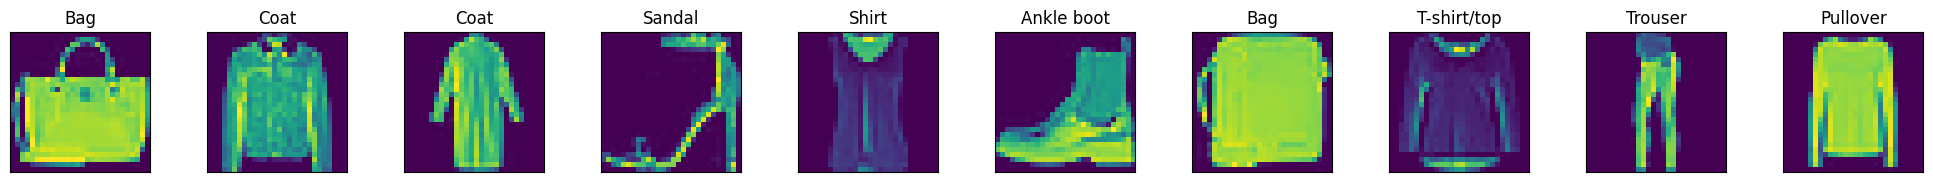

In [ ]:
# visualizing images in gird
def imshow(img):
    img = img/2 + 0.5 #unnormalize
    plt.imshow(np.transpose(img, (1,2,0))) #convert from tensor image

dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy() #converting images to numpy for display

fig = plt.figure(figsize=(25,4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(trainset.classes[labels[idx]])


### Training Function:
This function trains the neural network model with stochastic gradient descent (SGD) as the optimizer and cross-entropy as the loss objective function.
The training process includes both forward and backward passes. The model's parameters are updated in each epoch.

### Testing Function:
After training the model, we'll evaluate the model's performance on testing dataset. The evaluation will be done based on the accuracy of the model, which is the proportion of correctly predicted samples.

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
class ModelTrainer:
    def __init__(self, model, learning_rate=1, num_epochs=100):
        self.model = model
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.train_loss = []
        self.test_loss = []

    def train_model(self, loader, epoch):
        self.model.train()
        loss_list = []
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.loss_func(output, target)
            loss.backward()
            self.optimizer.step()
            loss_list.append(loss.item())
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx*len(data), len(loader.dataset),
                        100. * batch_idx / len(loader), loss.item()))
        avg_loss = sum(loss_list)/len(loss_list)
        self.train_loss.append(avg_loss)


    def test_model(self, loader):
        self.model.eval()
        test_loss = 0
        correct = 0
        loss_list = []
        with torch.no_grad():
            for data, target in loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                batch_loss = self.loss_func(output, target).item()  # Calculate the loss for this batch
                test_loss += batch_loss  # Add the batch loss to the total test loss
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                loss_list.append(batch_loss)  # Append the batch loss to the list

        avg_loss = sum(loss_list) / len(loss_list)
        self.test_loss.append(avg_loss)
        test_loss /= len(loader.dataset)
        accuracy = 100. * correct / len(loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(loader.dataset), accuracy))

    def run(self, trainloader, validloader):
        for epoch in range(self.num_epochs):
            self.train_model(trainloader, epoch)
            self.test_model(validloader)
        self.plot_loss()


    # TODO: Generate a plot of the training/testing loss vs. the number of epochs. (10pts)
    # Generate a plot of the training and testing loss vs. the number of epochs.
    def plot_loss(self):
        ######################################
        ######## WRITE YOUR CODE HERE ########
        ######################################
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, self.num_epochs + 1), self.train_loss, label='Training Loss', marker='o')
        plt.plot(range(1, self.num_epochs + 1), self.test_loss, label='Testing Loss', marker='x')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Testing Loss vs. Number of Epochs')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


    def plot_confusion_matrix(self):
        cm = confusion_matrix(self.all_targets, self.all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()


Train Epoch: 0 [5984/60000 (99%)]	Loss: 1.176441

Test set: Average loss: 0.0146, Accuracy: 35817/60000 (60%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 1.110034

Test set: Average loss: 0.0141, Accuracy: 35853/60000 (60%)



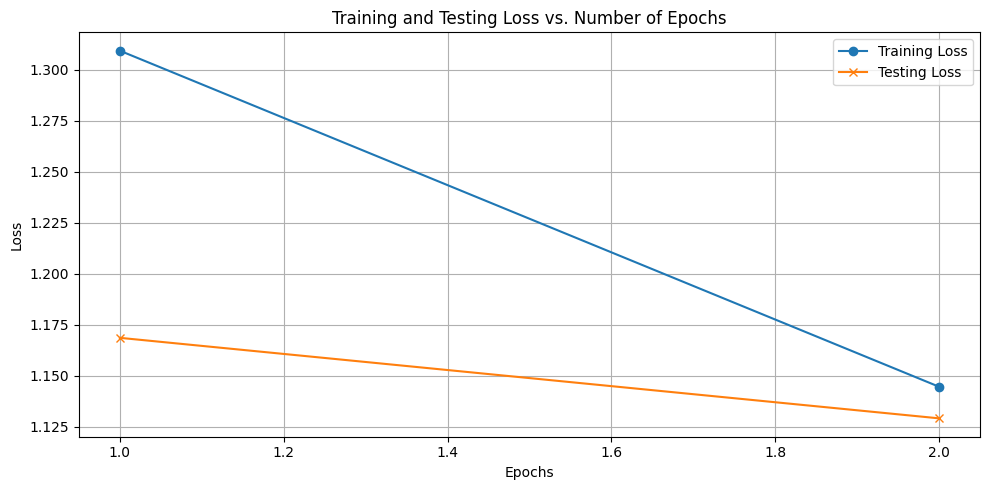


Test set: Average loss: 0.0179, Accuracy: 7416/10000 (74%)



In [ ]:
model = Classifier()
trainer = ModelTrainer(model=model, learning_rate=0.05, num_epochs=2)
trainer.run(trainloader, validloader)
trainer.test_model(testloader)

#### Task 1: Visualize the model's correct and incorrect predictions on the testing dataset using a confusion Matrix.(10 pts)

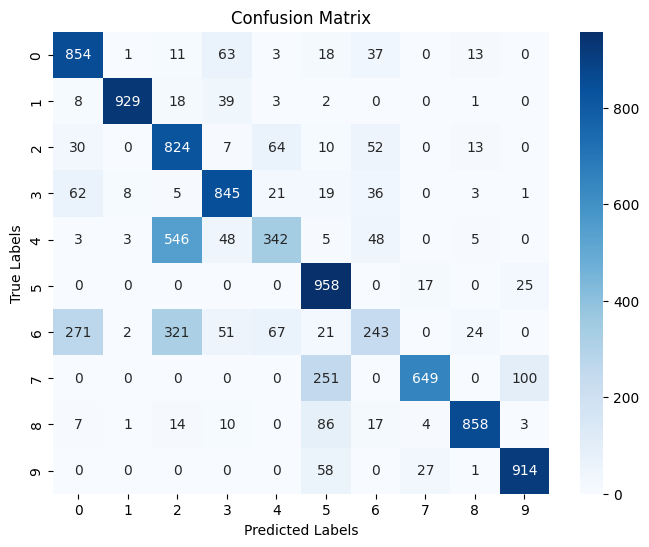

In [ ]:
######################################
######## WRITE YOUR CODE HERE ########
######################################


all_preds = []
all_targets = []

model.eval()  # evaluation
with torch.no_grad():
    for data, target in testloader:
        data, target = data.to(trainer.device), target.to(trainer.device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())



cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Machine learning involves a lot of experimentation. You might not always see large improvements, but every observation helps you understand how different parameters and design choices affect the model's performance. Focus on interpreting the results, not just achieving the best accuracy.

#### Task 2: Experiment with different learning rates and report your observations. Explain why the model performs better with some learning rates and worse with others. (10 pts)

For example, Keeping the other parameters the same, pick a high learning rate and observe the lose curve, accuracy. Then pick a low learning rate and observe the lose curve, accuracy. Find an optimal learning rate for your model and explain How learning rate affects the accuracy and lose change? What is the reason for this change?






My answer:

| learning rate | loss | test accuracy |
|:-----:|:-----:|:-----:|
| 0.5 | 0.0180 | 75% |
| 0.1 | 0.0179 | 74% |
|   0.05  |   0.0182  | 75% |
| 0.01 | 0.0209 | 72% |
|   0.005  |   0.0229  | 69% |
|   0.0005  |   0.0318  | 53% |

I experimented with 6 learning rates, ranging from 0.5 to 0.0005, and the results are listed in the above table. The model accuracy decreases as the learning rate decreases. The optimal learning rate for this model was 0.05, where the loss was 0.0182 and the test accuracy was 75%. One reason for the suboptimal results at lower learning rates might be that I only trained the model for 2 epochs. This was insufficient for smaller learning rates, leading to slower convergence and higher loss.

In [ ]:
######################################
######## WRITE YOUR CODE HERE ########
######################################

# answers are above

#### Task 3: Experiment and report your observations on how the model's performance changes using *three* different activation functions. (10 pts)
Read more here: [Activation functions](https://machinelearningmastery.com/activation-functions-in-pytorch/)

My answer:  
Experiment with learning rate = 0.05

| activation function | loss | test accuracy |
|:-----:|:-----:|:-----:|
| softmax | 0.0277 | 74% |
| sigmoid | 0.0273 | 62% |
|   logsoftmax  |   0.0085  | 80% |

Train Epoch: 0 [5984/60000 (99%)]	Loss: 1.814197

Test set: Average loss: 0.0235, Accuracy: 33690/60000 (56%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 1.700877

Test set: Average loss: 0.0220, Accuracy: 35428/60000 (59%)



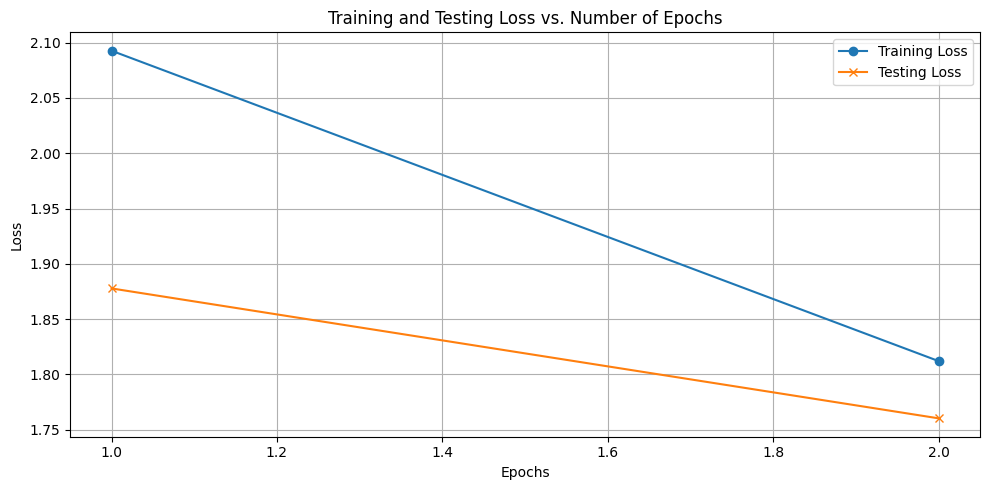


Test set: Average loss: 0.0277, Accuracy: 7355/10000 (74%)



In [ ]:
######################################
######## WRITE YOUR CODE HERE ########
######################################

# softmax
class Classifier_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120,10)
        #defining the 20% dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = self.dropout(F.relu(self.fc1(x)))
        #not using dropout on output layer
        x = self.fc2(x)
        x = F.softmax(x, dim=1)

        return x

model = Classifier_1()
trainer = ModelTrainer(model=model, learning_rate=0.05, num_epochs=2)
trainer.run(trainloader, validloader)
trainer.test_model(testloader)

Train Epoch: 0 [5984/60000 (99%)]	Loss: 1.838666

Test set: Average loss: 0.0226, Accuracy: 30472/60000 (51%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 1.740428

Test set: Average loss: 0.0217, Accuracy: 30242/60000 (50%)



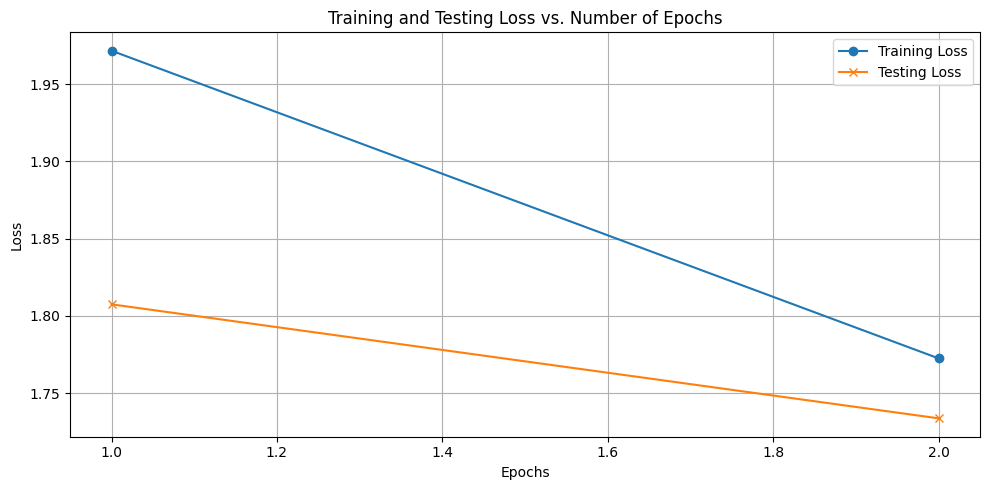


Test set: Average loss: 0.0273, Accuracy: 6228/10000 (62%)



In [ ]:
# sigmoid
class Classifier_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120,10)
        #defining the 20% dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = self.dropout(F.relu(self.fc1(x)))
        #not using dropout on output layer
        x = self.fc2(x)
        x = torch.sigmoid(x)

        return x

model = Classifier_2()
trainer = ModelTrainer(model=model, learning_rate=0.05, num_epochs=2)
trainer.run(trainloader, validloader)
trainer.test_model(testloader)

Train Epoch: 0 [5984/60000 (99%)]	Loss: 0.494259

Test set: Average loss: 0.0081, Accuracy: 36509/60000 (61%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 0.391090

Test set: Average loss: 0.0065, Accuracy: 39062/60000 (65%)



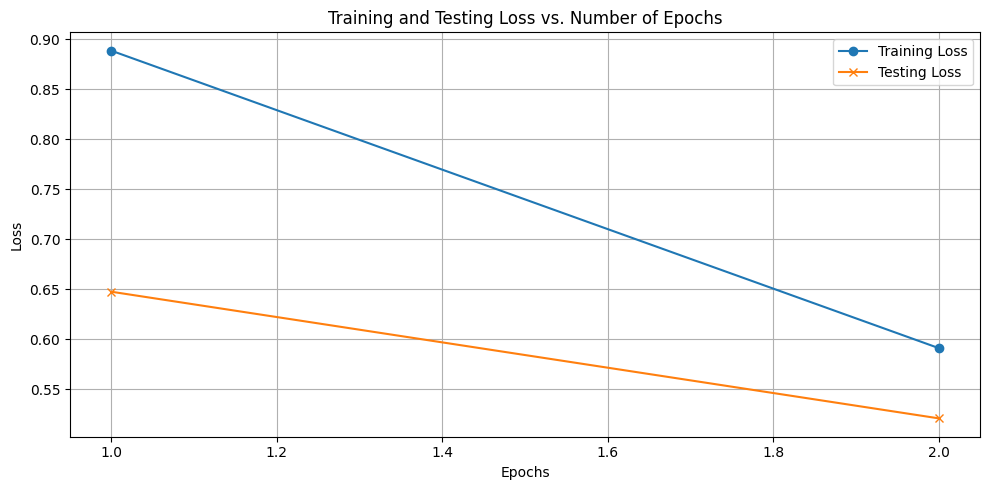


Test set: Average loss: 0.0085, Accuracy: 8023/10000 (80%)



In [ ]:
# logsoftmax
class Classifier_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120,10)
        #defining the 20% dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = self.dropout(F.relu(self.fc1(x)))
        #not using dropout on output layer
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)

        return x

model = Classifier_3()
trainer = ModelTrainer(model=model, learning_rate=0.05, num_epochs=2)
trainer.run(trainloader, validloader)
trainer.test_model(testloader)

#### Task 4: Experiment and report your observations on how the model's performance(testing accuracy) changes with different numbers of hidden neurons and different number of hidden layers. (15 pts)
For example pick a hidden layer with 1000 neurons and report the accuracy. Then pick a hidden layer with 10 neurons and report the accuracy. How does the accuracy change, how long does it take for each iteration? What is the reason for this change?


My answer:   

| number of hidden neurons | loss | test accuracy | time
|:-----:|:-----:|:-----:|:-----:|
| 1000 | 0.0180 | 78% | 21.68s
| 100 | 0.0183 | 75% | 22.09s
| 10  |   0.0196  | 74% | 27.84s

Through this experiment, we can see that models with more neurons have the best accruacy meaning that they have more capacity to learn complex patterns in the data. On the other hand, the model with only 10 neurons may underfit, meaning it doesn't have enough capacity to properly map the inputs to the outputs, which usually results in lower accuracy.

Through this experiment, we found that models with fewer neurons took longer per iteration, which is unexpected. Normally, models with more neurons take longer due to having more parameters and more computations. However, the smaller network may struggle to learn effectively, leading to slower training. With fewer neurons, the model may not capture the data's complexity, causing slower and less stable optimization.

In [ ]:
import time
class ModelTrainer:
    def __init__(self, model, learning_rate=1, num_epochs=100):
        self.model = model
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.train_loss = []
        self.test_loss = []

    def train_model(self, loader, epoch):
        # start_time = time.time() # time for training
        self.model.train()
        loss_list = []
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.loss_func(output, target)
            loss.backward()
            self.optimizer.step()
            loss_list.append(loss.item())
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx*len(data), len(loader.dataset),
                        100. * batch_idx / len(loader), loss.item()))
        avg_loss = sum(loss_list)/len(loss_list)
        self.train_loss.append(avg_loss)
        # end_time = time.time()
        # training_time = end_time - start_time
        # print(f"training time = {training_time:.2f} seconds")


    def test_model(self, loader):
        self.model.eval()
        test_loss = 0
        correct = 0
        loss_list = []
        with torch.no_grad():
            for data, target in loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                batch_loss = self.loss_func(output, target).item()  # Calculate the loss for this batch
                test_loss += batch_loss  # Add the batch loss to the total test loss
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                loss_list.append(batch_loss)  # Append the batch loss to the list

        avg_loss = sum(loss_list) / len(loss_list)
        self.test_loss.append(avg_loss)
        test_loss /= len(loader.dataset)
        accuracy = 100. * correct / len(loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(loader.dataset), accuracy))


    def run(self, trainloader, validloader):
        start_time = time.time()
        for epoch in range(self.num_epochs):
            self.train_model(trainloader, epoch)
            self.test_model(validloader)

        end_time = time.time()
        training_time = end_time - start_time
        print(f"training time = {training_time:.2f} seconds")
        print()
        self.plot_loss()



    # TODO: Generate a plot of the training/testing loss vs. the number of epochs. (10pts)
    # Generate a plot of the training and testing loss vs. the number of epochs.
    def plot_loss(self):
        ######################################
        ######## WRITE YOUR CODE HERE ########
        ######################################
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, self.num_epochs + 1), self.train_loss, label='Training Loss', marker='o')
        plt.plot(range(1, self.num_epochs + 1), self.test_loss, label='Testing Loss', marker='x')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Testing Loss vs. Number of Epochs')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

Train Epoch: 0 [5984/60000 (99%)]	Loss: 1.180621

Test set: Average loss: 0.0148, Accuracy: 36156/60000 (60%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 1.105260

Test set: Average loss: 0.0141, Accuracy: 36501/60000 (61%)

training time = 21.68 seconds



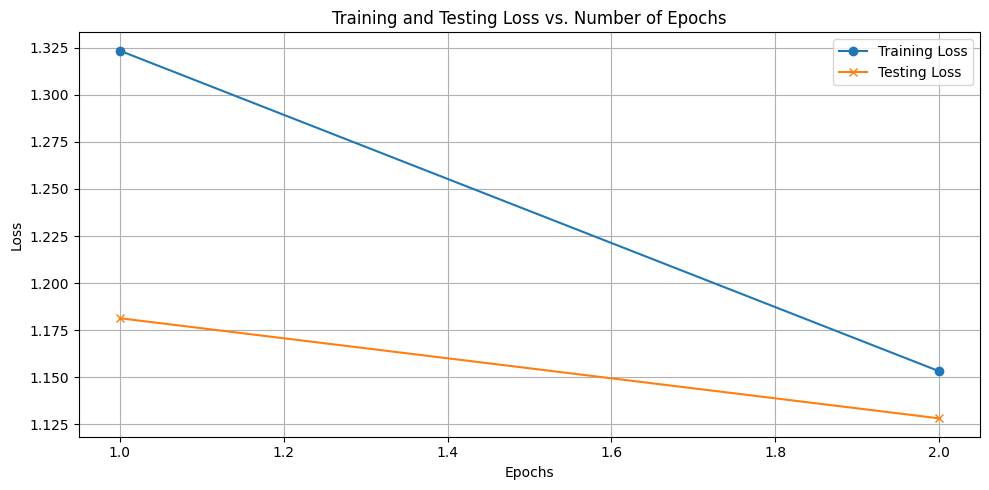


Test set: Average loss: 0.0179, Accuracy: 7537/10000 (75%)



In [ ]:
######################################
######## WRITE YOUR CODE HERE ########
######################################
class Classifier_4(nn.Module):
    def __init__(self, hidden_neurons):
        super().__init__()
        # Set the hidden layer size based on input parameter
        self.fc1 = nn.Linear(784, hidden_neurons)
        self.fc2 = nn.Linear(hidden_neurons, 10)
        # Defining the 20% dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        # Using tanh for output layer
        x = F.tanh(self.fc2(x))
        return x

# hidden_neurons=1000
model = Classifier_4(hidden_neurons=1000)
trainer = ModelTrainer(model=model, learning_rate=0.05, num_epochs=2)
trainer.run(trainloader, validloader)
trainer.test_model(testloader)



Train Epoch: 0 [5984/60000 (99%)]	Loss: 1.322522

Test set: Average loss: 0.0151, Accuracy: 35329/60000 (59%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 1.151987

Test set: Average loss: 0.0144, Accuracy: 35977/60000 (60%)

training time = 22.09 seconds



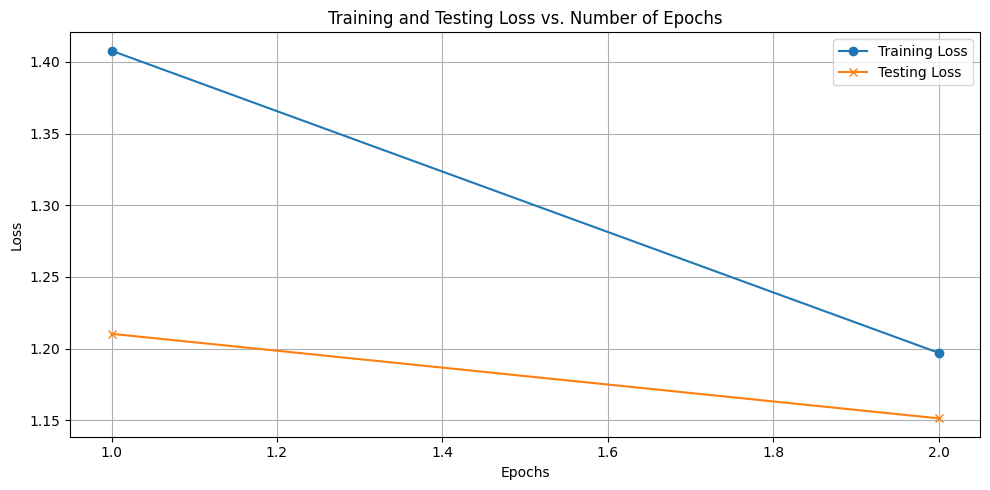


Test set: Average loss: 0.0183, Accuracy: 7424/10000 (74%)



In [ ]:
# hidden_neurons=100
model = Classifier_4(hidden_neurons=100)
trainer = ModelTrainer(model=model, learning_rate=0.05, num_epochs=2)
trainer.run(trainloader, validloader)
trainer.test_model(testloader)

Train Epoch: 0 [5984/60000 (99%)]	Loss: 1.347495

Test set: Average loss: 0.0168, Accuracy: 29789/60000 (50%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 1.503316

Test set: Average loss: 0.0159, Accuracy: 31159/60000 (52%)

training time = 27.84 seconds



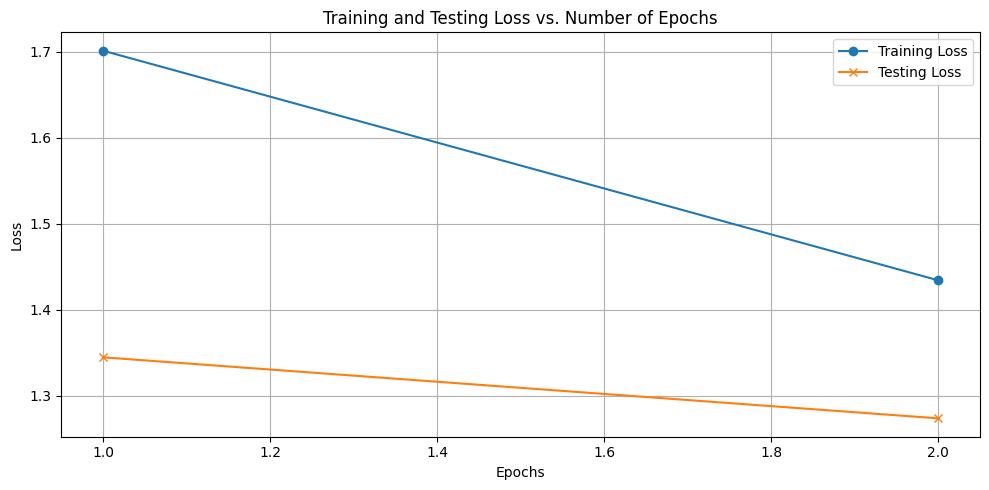


Test set: Average loss: 0.0201, Accuracy: 6389/10000 (64%)



In [ ]:
# hidden_neurons=10
model = Classifier_4(hidden_neurons=10)
trainer = ModelTrainer(model=model, learning_rate=0.05, num_epochs=2)
trainer.run(trainloader, validloader)
trainer.test_model(testloader)

#### Task 5: What did you learn from these experiments? (10 pts)

1. A lower learning rate does not always guarantee better model performance. There is an optimal learning rate at which the model performs best.
2. Activation functions introduce non-linearity to the neural network that enable the model to better classify different classes.
3. More neurons allow the model to learn more complex patterns, leading to better accuracy.
4. There might be a trade-off between model complexity and training efficiency.

## Exploring Web Interfaces of Large Language Models

### Objective:
This section is designed to help you become familiar with web interfaces of popular AI tools, including OpenAI GPT, Perplexity, and Grok. You will explore how these tools handle different types of prompts.
This exercise will help you understand and compare the capabilities and limitations of different large language model-based tools, providing insights into their real-world applications.

The task is to experiment with atleast 3 tools to compare and gain insights on how my perform and their limitations.

### Part 1: Task: Exploring Role-Specific Prompting (10 pts)
1. General Prompt:

Ask the tool a simple question, such as:
   - "How does a neural network work?"
   - "Explain how a recommendation system works."

2. Role-Specific Prompt:

Frame the same question by assigning a professional role to the tool. For example:
   - "You are a professor with 20 years of experience in machine learning. Explain how a neural network works."
   - "You are a data scientist working on Netflix's recommendation systems. Explain how a recommendation system works."
   
Observe and document how the response changes in detail, tone, and focus.

### Part 2: Math and Reasoning (10 pts)
1. Using the same three tools, provide prompts requiring logical reasoning and mathematical calculations. For instance:
   - "What is the sum of 123 and 456?"
   - "If it takes 3 hours to travel 180 miles, what is the speed in miles per hour?"
2. Compare the outputs for accuracy and coherence.


### Submission Instructions
- Take screenshots of the prompts and the corresponding responses for both tasks.
- Compile the screenshots into a single Zip file.
- Submit your document via the assignment portal.




## My Answer part 1

* How does a neural network work?  
* A neural network is a computational model inspired by the human brain. It works by processing data through layers of interconnected nodes (also called neurons), enabling the network to learn patterns and relationships in data. Here's how it works step-by-step:

1. Structure of a Neural Network
Input Layer: Receives raw data (e.g., images, text, numerical data).
Hidden Layers: Intermediate layers where computation happens. Each layer consists of neurons connected to the previous and next layers.
Output Layer: Produces the final result (e.g., classification, regression).
2. Forward Propagation
Input Data: Data is passed into the input layer.
Weighted Connections: Each connection between neurons has a weight, which adjusts the importance of the input.
Activation Function: Each neuron applies an activation function (e.g., ReLU, sigmoid) to its input. This introduces non-linearity, enabling the network to learn complex patterns.
Outputs: The processed data flows through the layers, producing outputs in the final layer.
3. Learning Through Backpropagation
The network adjusts its weights to minimize errors in predictions.
Calculate Loss: A loss function (e.g., Mean Squared Error, Cross-Entropy) measures the difference between the predicted output and the true output.
Backpropagation: The error is propagated backward through the network.
Gradients (rate of change of loss concerning weights) are calculated using the chain rule of calculus.
The gradients indicate how to adjust weights to reduce the error.
Update Weights: The weights are updated using optimization algorithms like Stochastic Gradient Descent (SGD) or Adam.
4. Training
The network repeatedly processes data in multiple passes (epochs), refining weights with each iteration to improve its performance.
5. Inference
Once trained, the network uses the learned weights to make predictions on new, unseen data.
Example Analogy: Predicting House Prices
Input Layer: Factors like area, number of rooms, and location.
Hidden Layers: Extract and combine patterns, such as the relationship between area and price.
Output Layer: Predicts the house price.
The network learns from training data, iteratively improving its price predictions.
Let me know if you'd like this expanded with a diagram or mathematical details!

* You are a professor with 20 years of experience in machine learning. Explain how a neural network works.
* Certainly! A neural network is a computational model inspired by the way biological neural networks in the human brain work. It is made up of layers of interconnected "neurons" (also called nodes) that process data and learn patterns to solve specific tasks. Here’s a step-by-step explanation:

1. Structure of a Neural Network
Input Layer: The input layer receives raw data (e.g., images, text, or numerical values) and passes it to the next layer. Each neuron here corresponds to a feature of the input data.
Hidden Layers: These layers perform intermediate computations. Each neuron in these layers applies a transformation to the data, often involving a weighted sum of inputs and a non-linear activation function.
Output Layer: This layer produces the final prediction or classification. For example, in an image recognition task, the output might represent the probability that the image belongs to certain categories (e.g., "cat" or "dog").
2. How Information Flows
Forward Propagation:
Each neuron calculates a weighted sum of its inputs:
𝑧 = ∑𝑖
(
𝑤
𝑖
⋅
𝑥
𝑖
)
+
𝑏
z=
i
∑
​
 (w
i
​
 ⋅x
i
​
 )+b
where
𝑤
𝑖
w
i
​
  are the weights,
𝑥
𝑖
x
i
​
  are the inputs, and
𝑏
b is the bias term.
The result,
𝑧
z, is passed through an activation function (e.g., ReLU, sigmoid) to introduce non-linearity and allow the network to learn complex patterns.
This process continues layer by layer until the output layer produces the final result.
3. Learning Process
Loss Function:
The network’s prediction is compared to the ground truth using a loss function, which measures the error. For instance, mean squared error (MSE) for regression or cross-entropy loss for classification.
Backpropagation:
The error is propagated backward through the network to update the weights and biases, using a technique called gradient descent (or one of its variants like Adam).
Gradients of the loss with respect to each weight are computed using the chain rule, enabling the network to adjust its parameters to minimize the error.
4. Training a Neural Network
Initialization: Weights and biases are initialized (randomly or with specific methods like Xavier initialization).
Epochs: The entire dataset is passed through the network multiple times.
Optimization: The optimizer (e.g., stochastic gradient descent) updates the weights iteratively to improve performance.
5. Key Properties
Non-linearity: Activation functions allow the network to learn non-linear relationships.
Feature Hierarchies: In deep networks, earlier layers learn simple features (like edges), while deeper layers learn more complex features (like shapes or objects).
Generalization: A well-trained network should perform well on unseen data.
6. Applications
Neural networks power many modern applications, such as:

Image recognition (e.g., detecting objects in photos).
Natural language processing (e.g., chatbots, translation).
Autonomous vehicles (e.g., identifying pedestrians and road signs).
Financial forecasting and more.
In essence, a neural network is a flexible and powerful tool for approximating complex functions, learning patterns in data, and making predictions.






## My Answer part 2

* What is the sum of 123 and 456?   
  The sum of 123 and 456 is: 123+456=579

* If it takes 3 hours to travel 180 miles, what is the speed in miles per hour?

To find the speed in miles per hour, use the formula:


Speed=
Time / Distance


Given:

Distance = 180 miles
Time = 3 hours

Speed= 180miles / 3hours =60miles per hour  
The speed is 60 miles per hour.


## OpenAI API Setup Instructions

### Step 1: Create an OpenAI Account
Go to the [OpenAI website](https://beta.openai.com/signup/) and create an account.
### Step 2: Get Your API Key
Once you've created an account and logged in, navigate to the API section in the dashboard. Here, you will have to create your own API key. Make sure to Copy this key for later use.

Note: You might need to make a minimum payment to use the API calls. You will be charged as per the number of API calls made. [Pricing](https://openai.com/api/pricing/)
### Step 3: Install the OpenAI Python Client
You can install the OpenAI Python client using pip. Open your terminal and run the following command:
```console
pip install openai
```
### Step 4: Use the API Key in Your Application
In your Python script, you can use the API key like this:

```python
import openai

openai.api_key = 'your-api-key'
```

Replace `'your-api-key'` with the API key you copied earlier.

### Step 5: Make API Calls
Now you can make API calls using the `openai` library. For example, to use the GPT-3 model, you can do something like this:
#### For Text Generation
```python
messages = [{"role": "user", "content": prompt}]
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=1,
    )
```

#### For Image Generation
```python
response = client.images.generate(
        model="dall-e-2",
        prompt= "Birthday cake with candles",
        n=1,
        size="1024x1024"
    )

That's it! You've successfully set up the OpenAI API.
For more Usages and examples refer the Docs Section
```

## OpenAI Setup Assignment

After successfully setting up the OpenAI API, you can now use it to complete the assignment. The assignment is divided into two parts:

### Part 1: Sentiment Analysis (10 pts)
In this part, you'll use the OpenAI API to generate text. You'll use the GPT-3 model for this task. Take input from the user and perform sentiment analysis on the input text. Based on the sentiment, generate a response using the GPT-3 model.

### Part 2: Image Generation (5 pts)
In this part, you'll use the OpenAI API to generate images. You'll use the DALL-E model for this task. Take input from the user and generate an image based on the input text.

 ###  *Store your API key in a file called open_ai_key.txt and upload it on Colab or give path to the text file if you are running it locally*


In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# fix file path in google colab
from google.colab import drive
drive.mount('/content/drive')

# change path
import os
os.chdir('/content/drive/MyDrive/LLMs')

Mounted at /content/drive


In [11]:
import openai
from openai import OpenAI
from PIL import Image
import urllib.request
from io import BytesIO
from IPython.display import display

class open_ai_a0:
    def __init__(self):
        api_key = self.load_key()
        self.client = OpenAI(api_key=api_key)

    # Loading OpenAI key from file #
    def load_key(self):
        open_ai_key_file = "open_ai_key.txt"
        with open(open_ai_key_file, "r") as f:
            for line in f:
                OPENAI_KEY = line.strip()  # strip to remove any trailing newline character
                return OPENAI_KEY

    def get_sentiment(self, text):
        # TODO: Write your prompt here for sentiment analysis on user provided text
        ######################################
        ######## WRITE YOUR PROMPT HERE ########
        ######################################
        # prompt = "The service was extremely slow, and the staff seemed uninterested in helping!"
        # messages = [{"role": "user", "content": prompt}]
        messages = [{"role": "user", "content": text}]
        response = self.client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=messages,
            temperature=1,
        )

        sentiment = response.choices[0].message.content
        print(sentiment)

    def text_to_image(self):
        response = self.client.images.generate(
            model="dall-e-2",
            # TODO: Write your prompt here for text to image
            ######################################
            ######## WRITE YOUR PROMPT HERE ########
            ######################################
            prompt= "Create a detailed image of a serene mountain landscape during sunrise. Include snow-capped peaks, a calm lake reflecting the golden hues of the sunrise, and a small wooden cabin with smoke coming from the chimney nestled among tall pine trees.",
            n=1,
            size="1024x1024"
        )
        image_url = response.data[0].url
        with urllib.request.urlopen(image_url) as image_url:
            img = Image.open(BytesIO(image_url.read()))

        display(img)


    def run(self):
        text = input("Enter a text: ")
        self.get_sentiment(text)
        self.text_to_image()

Enter a text: The service was extremely slow, and the staff seemed uninterested in helping.
I'm sorry to hear about your negative experience. Have you considered leaving feedback for the restaurant or speaking with a manager about the slow service and uninterested staff? It's important for businesses to know when they are not meeting customer expectations.


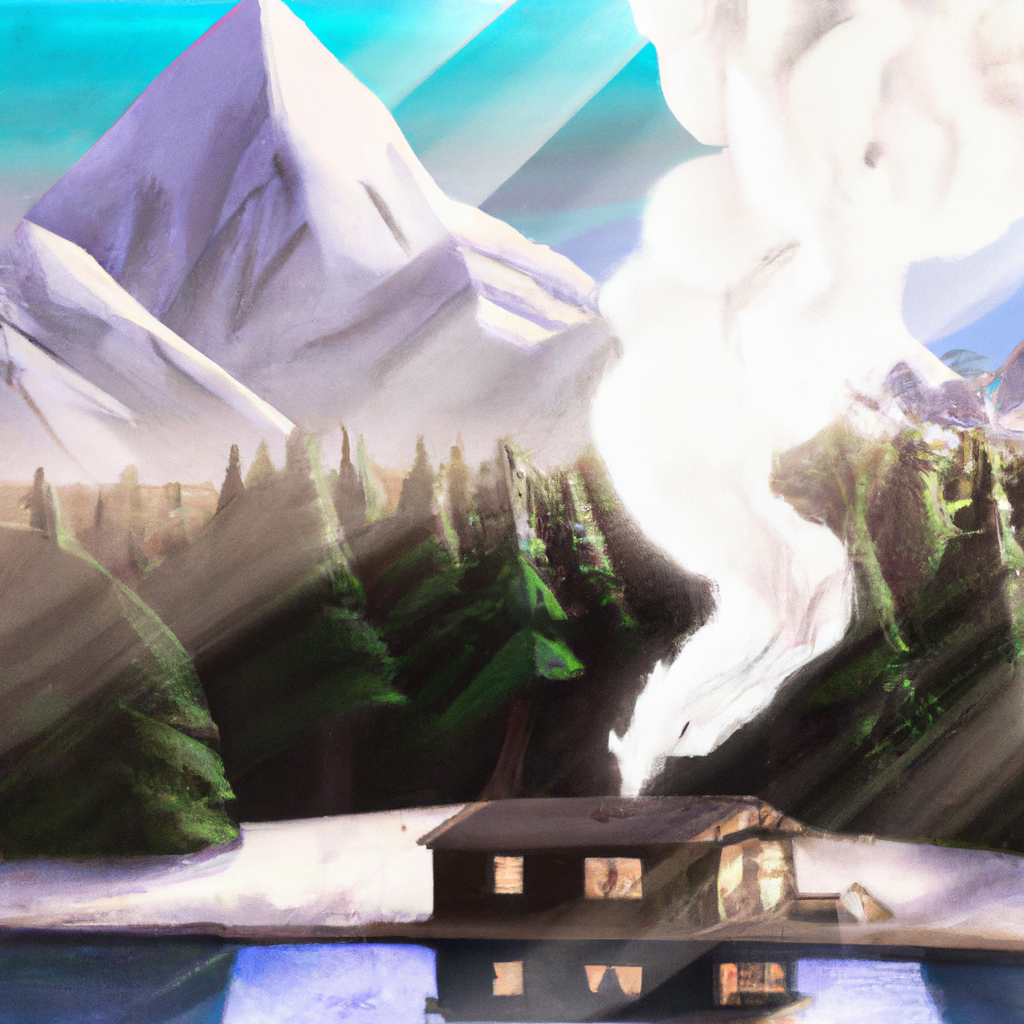

In [12]:
if __name__ == "__main__":
    obj = open_ai_a0()
    obj.run()